## 8.23

Download the hourly report of Utah air quality for 2015. Focus on north Provo data.

In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [33]:
data = pd.read_csv("2015-PM2.5.csv",index_col=0)
data.head()

Unnamed: 0     BR     BV     ED     H3     HA     HC     HW     L4  \
0            NaN     MC     MC     MC     MC     MC     MC     MC     MC   
1           Date  UG/M3  UG/M3  UG/M3  UG/M3  UG/M3  UG/M3  UG/M3  UG/M3   
2  1/1/2015 0:00    2.2   22.6    NaN    NaN   26.8    4.8    NaN   19.2   
3  1/1/2015 1:00    3.9   18.7    NaN    NaN   31.7    4.7    NaN   22.7   
4  1/1/2015 2:00    3.2   14.1    NaN    NaN   29.8    4.9    NaN   23.9   

      LN     NP     O2     RS     SM     T3     V4  
0     MC     MC     MC     MC     MC     MC     MC  
1  UG/M3  UG/M3  UG/M3  UG/M3  UG/M3  UG/M3  UG/M3  
2   23.9   19.2   14.9     10    NaN    8.3    NaN  
3   28.1   21.7   24.2     12    NaN    4.9    NaN  
4   25.8   19.3   12.2     12    NaN    2.9    NaN

In [85]:
provo = data.NP
# Cast any strings as NaN, clean them up
provo = pd.to_numeric(provo, errors="coerce").dropna()
provo.head()

Datetime
2015-01-01 00:00:00    19.2
2015-01-01 01:00:00    21.7
2015-01-01 02:00:00    19.3
2015-01-01 03:00:00    15.1
2015-01-01 04:00:00    12.8
Name: NP, dtype: float64

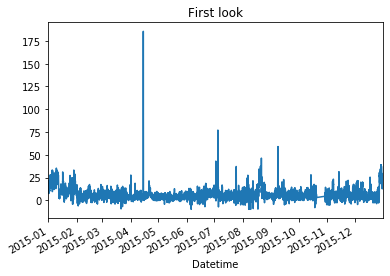

In [86]:
provo.plot()
plt.title("First look")
plt.show()

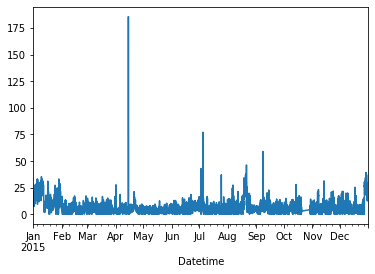

In [88]:
# Cast negative values as 0 micrograms/cubic meter
provo[provo < 0 ] = 0

# Resample and linearly interpolate values, because
# that approach assumes the least from the unknown data
provo = provo.resample("H").interpolate()
provo.plot()
plt.show()

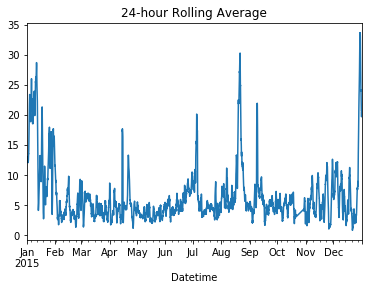

In [95]:
# a.) Estimate the trend with a symmetric length-24 moving average
T = provo.rolling(24).mean()
T.plot()
plt.title("24-hour Rolling Average")
plt.show()

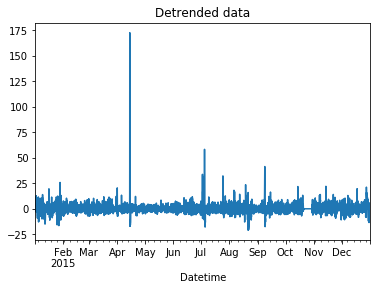

In [98]:
# b.) Detrend the original series
y = (provo - T).dropna()
y.plot()
plt.title("Detrended data")
plt.show()

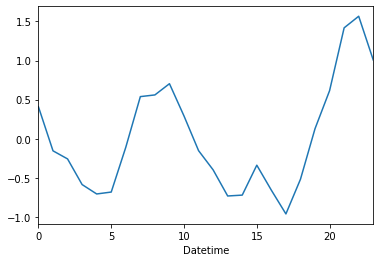

In [120]:
# c.) Compute the hour-of-the-day seasonal component
daily_mean = y.groupby(y.index.hour).mean()
daily_mean.plot()

# d.) Plot and interperet
plt.show()

It appears that the early morning hours are some of the cleanest in the day, then the hours of 6AM-10AM show an upward spike when commuter traffic kicks in, followed by a dip again until rush hour back home in the evening. Pollution continues to increase until nearly 11PM, at which time the rate drops for the night.

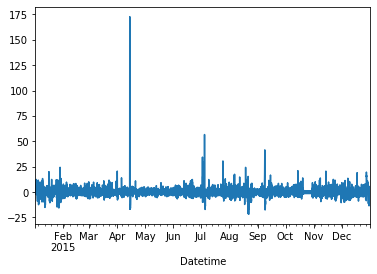

In [152]:
# e.) Remove hourly seasonal component from the de-trended data to get R.
# Plot the result
r = y.copy()
groups = r.groupby(r.index.hour)
for hour, rows in groups:
    r[rows.index] -= daily_mean[hour]
r.plot()
plt.show()

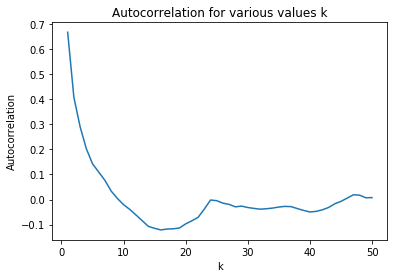

In [156]:
# f.) If the resulting time series is stationary,
# autocorrelation should be constant for each lag k.
autocorr = [r.autocorr(lag = i) for i in range(1,51)]
plt.plot(range(1,51),autocorr)
plt.xlabel("k")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation for various values k")
plt.show()

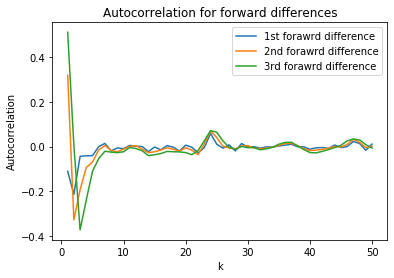

In [163]:
# g.) compute the j = [1,2,3] forward difference and plot the autocorrelations
r1 = r.shift(-1) - r
r2 = r.shift(-2) - r
r3 = r.shift(-3) - r

plt.plot(range(1,51), [r1.autocorr(lag = i) for i in range(1,51)], label="1st forawrd difference")
plt.plot(range(1,51), [r2.autocorr(lag = i) for i in range(1,51)], label="2nd forawrd difference")
plt.plot(range(1,51), [r3.autocorr(lag = i) for i in range(1,51)], label="3rd forawrd difference")
plt.legend()
plt.xlabel("k")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation for forward differences")
plt.show()